In [ ]:
! git clone https://github.com/hansam95/LG-Elec-Day9.git

In [1]:
import torch
torch.cuda.is_available()

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
np.random.seed(777)
torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

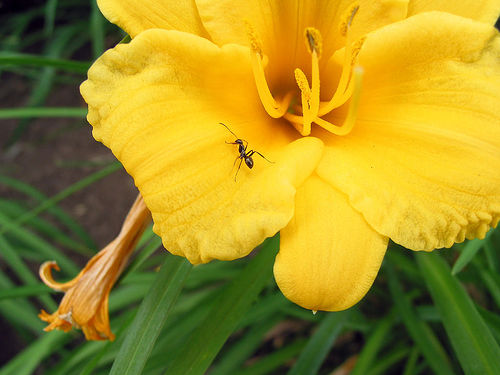

In [4]:
img = Image.open('/content/LG-Elec-Day9/data/ant_bee/train/ants/24335309_c5ea483bb8.jpg')
img

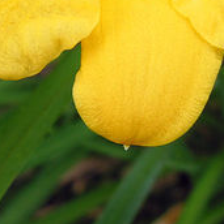

In [5]:
transforms.RandomResizedCrop(224, scale=(0.1,0.8))(img)

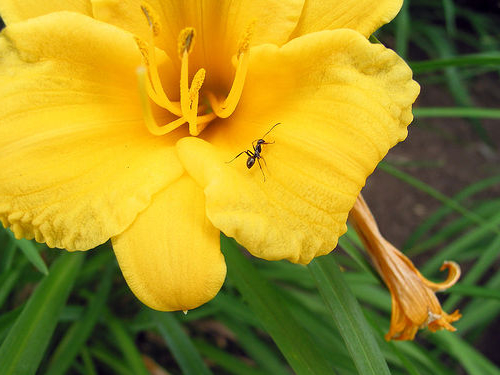

In [6]:
transforms.RandomHorizontalFlip(p=1)(img)

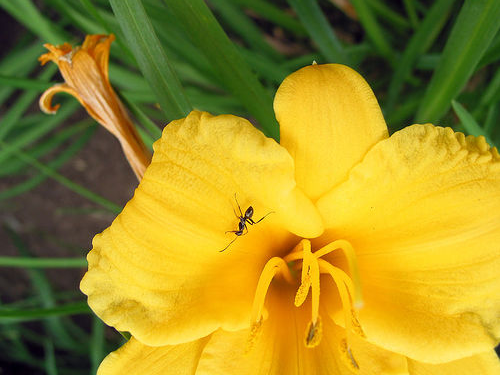

In [7]:
transforms.RandomVerticalFlip(p=1)(img)

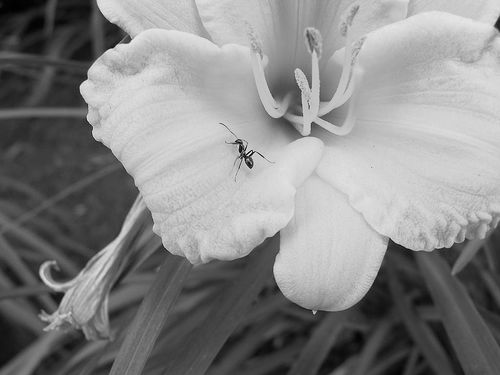

In [8]:
transforms.RandomGrayscale(p=1)(img)

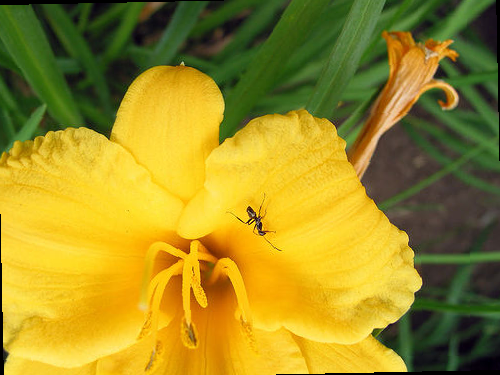

In [9]:
transforms.RandomRotation(degrees=(0,360))(img)

In [10]:
original_transforms = transforms.Compose([
    transforms.Resize(256), # size
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_transforms={'train':train_transform, 'val':val_transform}

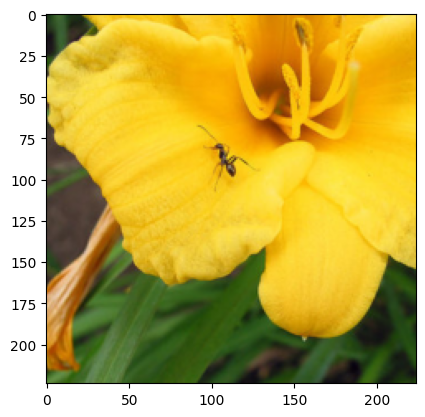

In [12]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

img1 = original_transforms(img)
plt.imshow(img1.permute(1,2,0)*std+mean)

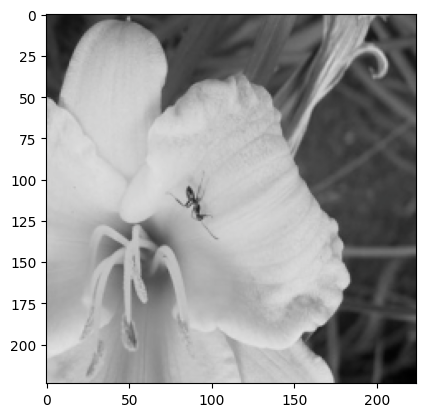

In [14]:
img1 = data_transforms['train'](img)
plt.imshow(img1.permute(1,2,0)*std+mean)

In [15]:
data_dir = "/content/LG-Elec-Day9/data/ant_bee"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = train_dataset.classes

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # channel, height, width -> height, width, channel
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # Given an interval, values outside the interval are clipped to the interval edges.
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

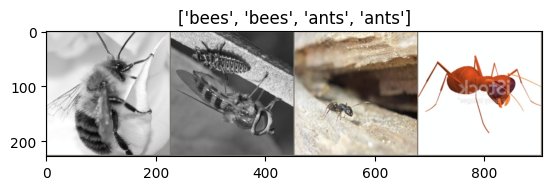

In [17]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train'])) # batch, ch, h,w
# Make a grid from batch
out = torchvision.utils.make_grid(inputs) # ch,h,width*batch
imshow(out, title=[class_names[x] for x in classes])

In [18]:
alexnet = models.alexnet(pretrained=True)

for param in alexnet.parameters():
    param.requires_grad = False

#Parameters of newly constructed modules have requires_grad=True by default
num_in = alexnet.classifier[-1].in_features
alexnet.classifier[-1] = nn.Linear(num_in,2)

alexnet

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

<img src='img/img5.png' width='800'></img>

In [20]:
alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.classifier[-1].parameters(), lr=0.01)

lr_schedule = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
num_epochs = 10

In [22]:
best_acc = 0.0

# epoch
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            alexnet.train()  # Set model to training mode
        else:
            alexnet.eval()   # Set model to evaluate mode
    
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = alexnet(inputs)
                _, preds = torch.max(outputs, 1) #outputs값 중에서 큰 class값을 가져옴
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward() # backpropagation
                    optimizer.step() # model weight update
            
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase] #float은 7자리, double은 15~16자리까지 표현가능
        
        lr = lr_schedule.get_last_lr()[0]
        print('{} Loss: {:.4f} Acc: {:.4f} LR: {:.6f}'.format(
                phase, epoch_loss, epoch_acc, lr))

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            content = {
                'epoch': epoch,
                'acc': epoch_acc,
                'model': alexnet.state_dict()
            }
            torch.save(content, 'alex_best2.pt')
     
    # learning rate scheduler
    lr_schedule.step()

print('Best val Acc: {:4f}'.format(best_acc))

Epoch 1/10
----------
train Loss: 0.6315 Acc: 0.9549 LR: 0.009044
val Loss: 2.2956 Acc: 0.9150 LR: 0.009044
Epoch 2/10
----------
train Loss: 1.8652 Acc: 0.9057 LR: 0.008953
val Loss: 3.0651 Acc: 0.8954 LR: 0.008953
Epoch 3/10
----------
train Loss: 1.3066 Acc: 0.9344 LR: 0.008864
val Loss: 3.4462 Acc: 0.9085 LR: 0.008864
Epoch 4/10
----------
train Loss: 0.9719 Acc: 0.9344 LR: 0.008775
val Loss: 2.6478 Acc: 0.8889 LR: 0.008775
Epoch 5/10
----------
train Loss: 1.2664 Acc: 0.9344 LR: 0.008687
val Loss: 2.7451 Acc: 0.9150 LR: 0.008687
Epoch 6/10
----------
train Loss: 1.9669 Acc: 0.9344 LR: 0.008601
val Loss: 3.3571 Acc: 0.9020 LR: 0.008601
Epoch 7/10
----------
train Loss: 1.2520 Acc: 0.9303 LR: 0.008515
val Loss: 2.8638 Acc: 0.9020 LR: 0.008515
Epoch 8/10
----------
train Loss: 1.8417 Acc: 0.9262 LR: 0.008429
val Loss: 3.6114 Acc: 0.8889 LR: 0.008429
Epoch 9/10
----------
train Loss: 1.1767 Acc: 0.9385 LR: 0.008345
val Loss: 4.3545 Acc: 0.8627 LR: 0.008345
Epoch 10/10
----------
train

In [23]:
ckpt = torch.load('alex_best2.pt')
alexnet.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [24]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.subplot(num_images//2, 2, images_so_far)
                plt.axis('off')
                plt.title('real: {} | predicted: {}'.format(class_names[labels[j]],
                                                            class_names[preds[j]]))
                img = inputs.cpu().data[j].permute(1,2,0)*std+mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    return

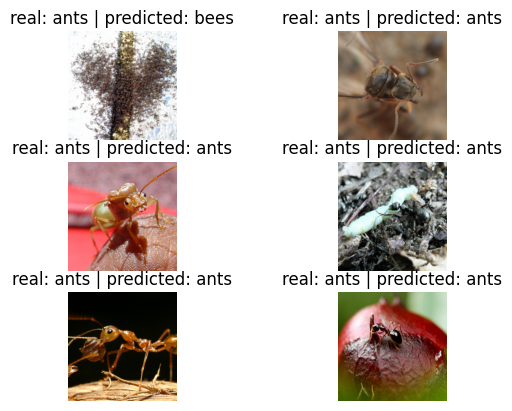

In [25]:
visualize_model(alexnet)

## Time Series Data Augmentation

In [26]:
def create_data(path, filename):
    with open(os.path.join(path, filename)) as f:
        data = []
        for line in f:
            num = [float(l) for l in line.split()]
            data.append(num)
    data = np.array(data).reshape(-1,128)

    return data

In [27]:
train_path = '/content/LG-Elec-Day9/data/UCI HAR Dataset/train/Inertial Signals'
test_path = '/content/LG-Elec-Day9/data/UCI HAR Dataset/test/Inertial Signals'
train_dir_lst = sorted(os.listdir(train_path))
test_dir_lst = sorted(os.listdir(test_path))

In [28]:
train_data = []
for i in range(len(train_dir_lst)):
    data = create_data(train_path, train_dir_lst[i])
    train_data.append(data)
train_data = np.transpose(np.array(train_data),(1,0,2))

test_data = []
for i in range(len(test_dir_lst)):
    data = create_data(test_path, test_dir_lst[i])
    test_data.append(data)
test_data = np.transpose(np.array(test_data),(1,0,2))

In [30]:
# 1~6 으로 class label이 형성되어 있으므로 0~5까지 맞춰주기 위해서 -1 
# 0(Walking) / 1(Walking Upstairs) / 2(Walking Downstairs) / 3(Sitting) / 4(Standing) / 5(Laying)
train_label = pd.read_csv('./data/UCI HAR Dataset/train/y_train.txt',header=None,sep=' ')
train_label = np.array(train_label[0])-1

test_label = pd.read_csv('./data/UCI HAR Dataset/test/y_test.txt',header=None,sep=' ')
test_label = np.array(test_label[0])-1

In [31]:
# train 데이터를 활용하여 val 데이터 생성 ( train : val = 8 : 2)
len_train = int(len(train_data) * 0.8)

new_train_data = train_data[:len_train,:,:]
new_train_label = train_label[:len_train]

val_data = train_data[len_train:,:,:]
val_label = train_label[len_train:]

In [32]:
def TS_Jitter(X, sigma=0.001):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

def TS_Scaling(X, sigma=0.2):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [34]:
ts = new_train_data[0]
ts_jitter = TS_Jitter(ts)
ts_scale = TS_Scaling(ts)

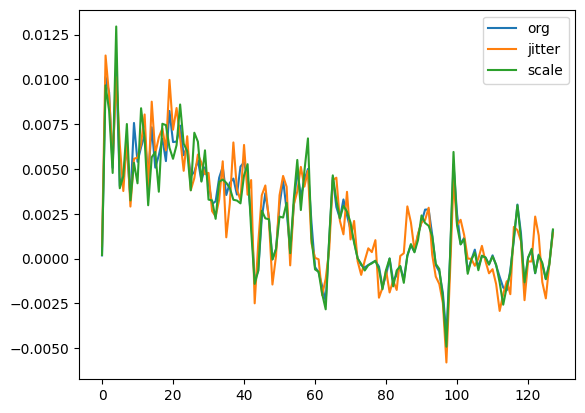

In [35]:
plt.plot(ts[0], label='org')
plt.plot(ts_jitter[0], label='jitter')
plt.plot(ts_scale[0], label='scale')
plt.legend()
plt.show()

In [36]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, jitter=False, scale=False, p=0.5):
        assert X.size(0)==y.size(0)
        self.jitter = jitter
        self.scale = scale
        self.X = X
        self.y = y
        self.p = p

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        
        rand_num = np.random.uniform()
        if self.jitter and rand_num>self.p:
            X = TS_Jitter(X)
        if self.scale and rand_num>self.p:
            X = TS_Scaling(X)
        
        return X.float(), y

In [37]:
train_dataset = TSDataset(torch.Tensor(new_train_data), torch.Tensor(new_train_label), jitter=True, scale=True)
val_dataset = TSDataset(torch.Tensor(val_data),torch.Tensor(val_label), jitter=True, scale=True)
test_dataset = TSDataset(torch.Tensor(test_data),torch.Tensor(test_label), jitter=True, scale=True)

In [38]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100)

In [39]:
class CNN_1d(nn.Module):
    def __init__(self,num_classes=6):
        super().__init__()
        
        '''모델에 필요한 layer 정의'''
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(9,196,kernel_size=6),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(196,64,kernel_size =6),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.classifier = nn.Linear(64*28,num_classes)
        
    def forward(self,x):
        
        ''' x를 입력받아 진행할 순서 설정 '''
        
        out = self.conv1(x) 
        out = self.conv2(out) 
        out = out.view(out.size(0),-1)
        out = self.classifier(out)
        
        return out

In [40]:
model = CNN_1d()
model

CNN_1d(
  (conv1): Sequential(
    (0): Conv1d(9, 196, kernel_size=(6,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(196, 64, kernel_size=(6,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=1792, out_features=6, bias=True)
)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [42]:
model.to(device)

num_epochs = 20

print("Start Training !")
print('-'*50)
print()

train_loss_total = []
val_loss_total = []
best_loss = np.inf

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    
    train_loss = 0
    val_loss = 0
    train_corrects = 0
    val_corrects = 0
    
    
    '''Train'''
    # 모델을 학습모드로 전환
    model.train()
    
    for inputs,labels in train_loader:
        # 데이터를 'gpu' or 'cpu' 로 이동
        inputs = inputs.to(device)
        labels = labels.to(device).long()
        
        
        # 모델의 모든 기울기 값을 0으로 설정
        optimizer.zero_grad()
        
        # 데이터를 모델에 입력하여 출력값 계산
        outputs = model(inputs)
        
        #outputs값 중에서 큰 class값을 가져옴
        _,preds = torch.max(outputs,1)
        
        # 비용함수를 활용하여 오차 계산
        loss = criterion(outputs,labels)
        
        # 계산된 오차를 기반으로 기울기 계산
        loss.backward()
        
        # 계산된 기울기를 바탕으로 모델의 파라미터 업데이트
        optimizer.step()
        
        train_loss += loss.item()
        train_corrects += torch.sum(preds == labels.data)
    
    '''Validation'''
    # 모델을 평가모드로 전환
    model.eval()
    # 모델을 평가할때는 기울기 계산 불필요
    with torch.no_grad():
        for inputs,labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()
            
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == labels.data)
    
    # epoch의 loss 계산
    train_loss_epoch = train_loss/len(train_loader)
    val_loss_epoch = val_loss/len(val_loader)
    
    #epoch의 accuracy 계산
    train_acc_epoch = train_corrects / len(train_dataset)
    val_acc_epoch = val_corrects / len(val_dataset)

    print(f'{epoch+1} epoch | Train loss: {train_loss_epoch:.3f}, Valid loss: {val_loss_epoch:.3f}')
    print(f'{epoch+1} epoch | Train acc: {train_acc_epoch:.3f}, Valid acc: {val_acc_epoch:.3f}')
    print()

    # validation loss 기준으로 best epoch 계산 (Early stopping)
    if val_loss_epoch < best_loss:
        # best loss 업데이트
        best_loss = val_loss_epoch
        # 최적의 epoch 수와 모델 저장하기
        best_epoch = epoch
        torch.save(model.state_dict(), './best_model_HAR.pt')
    
    train_loss_total.append(train_loss_epoch)
    val_loss_total.append(val_loss_epoch)

print()
print('-'*50)
print(f'Finished Training ! Best Epoch is epoch {best_epoch+1}')

Start Training !
--------------------------------------------------

Epoch 1/20
----------
1 epoch | Train loss: 1.474, Valid loss: 1.106
1 epoch | Train acc: 0.443, Valid acc: 0.743

Epoch 2/20
----------
2 epoch | Train loss: 0.800, Valid loss: 0.761
2 epoch | Train acc: 0.713, Valid acc: 0.720

Epoch 3/20
----------
3 epoch | Train loss: 0.560, Valid loss: 0.672
3 epoch | Train acc: 0.791, Valid acc: 0.784

Epoch 4/20
----------
4 epoch | Train loss: 0.459, Valid loss: 0.602
4 epoch | Train acc: 0.821, Valid acc: 0.854

Epoch 5/20
----------
5 epoch | Train loss: 0.394, Valid loss: 0.558
5 epoch | Train acc: 0.849, Valid acc: 0.846

Epoch 6/20
----------
6 epoch | Train loss: 0.341, Valid loss: 0.521
6 epoch | Train acc: 0.883, Valid acc: 0.878

Epoch 7/20
----------
7 epoch | Train loss: 0.299, Valid loss: 0.485
7 epoch | Train acc: 0.899, Valid acc: 0.889

Epoch 8/20
----------
8 epoch | Train loss: 0.255, Valid loss: 0.460
8 epoch | Train acc: 0.923, Valid acc: 0.892

Epoch 9/20


In [43]:
model = CNN_1d()
# 최적의 모델 불러오기
ckpt = torch.load('./best_model_HAR.pt')
# 모델 파라미터 불러오기
model.load_state_dict(ckpt)

<All keys matched successfully>

In [44]:
# model을 evaluation 모드로 변경
pred_list = []
true_list = []

model.eval()

with torch.no_grad():
    for inputs,labels in test_loader:
        # 모델의 출력값 계산
        y_logit = model(inputs)
        # 출력값을 최대로하는 인덱스(class) 저장
        y_pred = torch.argmax(y_logit, dim=1)

        # 예측값과 실제값 저장
        pred_list.extend(y_pred.detach().numpy())
        true_list.extend(labels.detach().numpy())

In [45]:
# 평가지표 계산
test_acc = accuracy_score(true_list, pred_list)
test_rec = recall_score(true_list, pred_list, average='macro')
test_prec = precision_score(true_list, pred_list, average='macro')
test_f1 = f1_score(true_list, pred_list, average='macro')

print('Test Accuracy   : {:.3f}'.format(test_acc))
print('Test Sensitivity: {:.3f}'.format(test_rec))
print('Test Precision  : {:.3f}'.format(test_prec))
print('Test F1 Score   : {:.3f}'.format(test_f1))

Test Accuracy   : 0.895
Test Sensitivity: 0.896
Test Precision  : 0.897
Test F1 Score   : 0.895
